# Modeling

In [1]:
!pwd

/home/jovyan/work/cold_start_models


In [34]:
from sklearn import metrics
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as mae, r2_score as r2
from scipy.stats import uniform, randint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split


# warnings


def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(y_test, y_pred, X):

    mse1 = mse(y_test, y_pred)

    rmse1 = rmse(y_test, y_pred)

    mae1 = mae(y_test, y_pred)

    medae1 = medae(y_test, y_pred)

    R21 = R2(y_test, y_pred)
    
    adj_r2 = 1 - (1-r2(y_test, y_pred)) * (len(y)-1)/(len(y)-X.shape[1]-1)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}\nAdj_R2:  {}".format(mse1, rmse1, R21, mae1, medae1, adj_r2))
    print('-'*30)


def get_importance(train_dataset, cat_model, title='Catboost feature importance', save_fig=False, file_name='cat_feature_importance.png'):
    imp = cat_model.get_feature_importance(data=train_dataset)
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp, y=cat_model.feature_names_)
    axes.set_title(title)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    

def draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution'):
    plt.figure(figsize=(12, 5))
    sns.distplot(y_test)
    sns.distplot(y_pred)
    plt.legend(['test', 'pred'])
    if save_fig:
        plt.savefig(file_name)
    plt.show()

    
def draw_residuals(y_test, y_pred, save_fig=False,
                   file_name='cat_residuals.png'):
    sns.residplot(x=y_test, y=y_pred)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    
    
class TargetTransformer:
    def __init__(self, denominator=1):
        self.scale = denominator
        
    def inverse_transform(self, feature):
        return feature.apply(lambda x: np.expm1(x))
    
    def transform(self, feature):
        return feature.apply(lambda x: np.log1p(x))
    
    
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.show()

In [3]:
with open('/home/jovyan/work/cold_start_models/dataset_2kp.pkl', 'rb') as f:
    df_pr = pickle.load(f)

In [4]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10017 entries, 0 to 10016
Columns: 225 entries, name_x to war_movies
dtypes: float64(221), object(4)
memory usage: 17.3+ MB


In [5]:
df_pr.columns

Index(['name_x', 'age_access_type_x', 'duration_x', 'type_x', 'release_year_x',
       'BUDGET', 'MARKETING', 'RUS', 'WORLD', 'target',
       ...
       'forkids', 'history', 'horror', 'humor', 'melodrama', 'music', 'sci-fi',
       'sport', 'thriller', 'war_movies'],
      dtype='object', length=225)

# 5

In [24]:
cat_features = ['type_x','age_access_type_x']
num_features = [
 'duration_x',
 'BUDGET',
 'MARKETING',
 'RUS',
 'WORLD',
 'country_x_0',
 'country_x_1',
 'country_x_2',
 'country_x_3',
 'country_x_4',
 'country_x_5',
 'country_x_6',
 'country_x_7',
 'country_x_8',
 'country_x_9',
 'country_x_10',
 'country_x_11',
 'country_x_12',
 'country_x_13',
 'country_x_14',
 'country_x_15',
 'country_x_16',
 'country_x_17',
 'country_x_18',
 'country_x_19',
 'country_x_20',
 'country_x_21',
 'country_x_22',
 'country_x_23',
 'ACTOR_0',
 'ACTOR_1',
 'ACTOR_2',
 'ACTOR_3',
 'ACTOR_4',
 'ACTOR_5',
 'ACTOR_6',
 'ACTOR_7',
 'ACTOR_8',
 'ACTOR_9',
 'ACTOR_10',
 'ACTOR_11',
 'ACTOR_12',
 'ACTOR_13',
 'ACTOR_14',
 'ACTOR_15',
 'ACTOR_16',
 'ACTOR_17',
 'ACTOR_18',
 'ACTOR_19',
 'ACTOR_20',
 'ACTOR_21',
 'ACTOR_22',
 'ACTOR_23',
 'COMPOSER_0',
 'COMPOSER_1',
 'COMPOSER_2',
 'COMPOSER_3',
 'COMPOSER_4',
 'COMPOSER_5',
 'COMPOSER_6',
 'COMPOSER_7',
 'COMPOSER_8',
 'COMPOSER_9',
 'COMPOSER_10',
 'COMPOSER_11',
 'COMPOSER_12',
 'COMPOSER_13',
 'COMPOSER_14',
 'COMPOSER_15',
 'COMPOSER_16',
 'COMPOSER_17',
 'COMPOSER_18',
 'COMPOSER_19',
 'COMPOSER_20',
 'COMPOSER_21',
 'COMPOSER_22',
 'COMPOSER_23',
 'DIRECTOR_0',
 'DIRECTOR_1',
 'DIRECTOR_2',
 'DIRECTOR_3',
 'DIRECTOR_4',
 'DIRECTOR_5',
 'DIRECTOR_6',
 'DIRECTOR_7',
 'DIRECTOR_8',
 'DIRECTOR_9',
 'DIRECTOR_10',
 'DIRECTOR_11',
 'DIRECTOR_12',
 'DIRECTOR_13',
 'DIRECTOR_14',
 'DIRECTOR_15',
 'DIRECTOR_16',
 'DIRECTOR_17',
 'DIRECTOR_18',
 'DIRECTOR_19',
 'DIRECTOR_20',
 'DIRECTOR_21',
 'DIRECTOR_22',
 'DIRECTOR_23',
 'EDITOR_0',
 'EDITOR_1',
 'EDITOR_2',
 'EDITOR_3',
 'EDITOR_4',
 'EDITOR_5',
 'EDITOR_6',
 'EDITOR_7',
 'EDITOR_8',
 'EDITOR_9',
 'EDITOR_10',
 'EDITOR_11',
 'EDITOR_12',
 'EDITOR_13',
 'EDITOR_14',
 'EDITOR_15',
 'EDITOR_16',
 'EDITOR_17',
 'EDITOR_18',
 'EDITOR_19',
 'EDITOR_20',
 'EDITOR_21',
 'EDITOR_22',
 'EDITOR_23',
 'OPERATOR_0',
 'OPERATOR_1',
 'OPERATOR_2',
 'OPERATOR_3',
 'OPERATOR_4',
 'OPERATOR_5',
 'OPERATOR_6',
 'OPERATOR_7',
 'OPERATOR_8',
 'OPERATOR_9',
 'OPERATOR_10',
 'OPERATOR_11',
 'OPERATOR_12',
 'OPERATOR_13',
 'OPERATOR_14',
 'OPERATOR_15',
 'OPERATOR_16',
 'OPERATOR_17',
 'OPERATOR_18',
 'OPERATOR_19',
 'OPERATOR_20',
 'OPERATOR_21',
 'OPERATOR_22',
 'OPERATOR_23',
 'PRODUCER_0',
 'PRODUCER_1',
 'PRODUCER_2',
 'PRODUCER_3',
 'PRODUCER_4',
 'PRODUCER_5',
 'PRODUCER_6',
 'PRODUCER_7',
 'PRODUCER_8',
 'PRODUCER_9',
 'PRODUCER_10',
 'PRODUCER_11',
 'PRODUCER_12',
 'PRODUCER_13',
 'PRODUCER_14',
 'PRODUCER_15',
 'PRODUCER_16',
 'PRODUCER_17',
 'PRODUCER_18',
 'PRODUCER_19',
 'PRODUCER_20',
 'PRODUCER_21',
 'PRODUCER_22',
 'PRODUCER_23',
 'WRITER_0',
 'WRITER_1',
 'WRITER_2',
 'WRITER_3',
 'WRITER_4',
 'WRITER_5',
 'WRITER_6',
 'WRITER_7',
 'WRITER_8',
 'WRITER_9',
 'WRITER_10',
 'WRITER_11',
 'WRITER_12',
 'WRITER_13',
 'WRITER_14',
 'WRITER_15',
 'WRITER_16',
 'WRITER_17',
 'WRITER_18',
 'WRITER_19',
 'WRITER_20',
 'WRITER_21',
 'WRITER_22',
 'WRITER_23',
 'action',
 'adventure',
 'anime',
 'biography',
 'cartoons',
 'comedy',
 'crime',
 'detective',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'forkids',
 'history',
 'horror',
 'humor',
 'melodrama',
 'music',
 'sci-fi',
 'sport',
 'thriller',
 'war_movies']

In [11]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10017 entries, 0 to 10016
Columns: 225 entries, name_x to war_movies
dtypes: float64(221), object(4)
memory usage: 17.3+ MB


In [25]:
df_pr[num_features] = df_pr[num_features].astype(float)
df_pr[cat_features] = df_pr[cat_features].astype('category')

In [26]:
df_pr_short = df_pr[df_pr['target'] > 50]
df_pr_short.index = range(len(df_pr_short))
X, y = df_pr.drop(['target', 'release_year_x', 'name_x', 'uid'], axis=1), df_pr['target']

X_train, X_test, y_train, y_test = X[df_pr['release_year_x'].astype(float) < 2022],  X[df_pr['release_year_x'].astype(float) >= 2022], y[df_pr['release_year_x'].astype(float) < 2022],  y[df_pr['release_year_x'].astype(float) >= 2022]
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)


origs = ['ee48def6-c311-4b73-a878-1a5d3d1679a3',
'9b202b16-55bf-418a-b01d-9f0329b18790',
'49a3d528-44c0-408e-b6fc-a1507ce7641a'
        ]

orig_ids = [7749, 8127, 8285]

X_train.drop(orig_ids, axis=0, inplace=True)
y_train.drop(orig_ids, axis=0, inplace=True)
X_test = pd.concat([X_test, X.iloc[orig_ids, :]])
y_test = pd.concat([y_test, y.iloc[orig_ids]])


df_pr_short[df_pr_short['uid'].isin(origs)]

/tmp/ipykernel_220/2248617195.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(orig_ids, axis=0, inplace=True)


,name_x,age_access_type_x,duration_x,type_x,release_year_x,BUDGET,MARKETING,RUS,WORLD,target,...,forkids,history,horror,humor,melodrama,music,sci-fi,sport,thriller,war_movies
5995,Чикатило,18,49800000.0,SERIAL,2020.0,NaN,NaN,NaN,NaN,100978.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.451247,0.0
6290,Манюня,6,11640000.0,SERIAL,2021.0,NaN,NaN,NaN,NaN,57462.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
6434,Оффлайн,18,30060000.0,SERIAL,2022.0,NaN,NaN,NaN,NaN,105171.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.537779,0.0


In [27]:
df_pr_short.shape

(6466, 225)

In [28]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression', metric='rmse')

params = {
   'num_leaves': randint(20, 3000) ,
   'min_data_in_leaf': randint(3, 10),
   'max_depth': randint(5, 15),
   'n_estimators': randint(500, 10000),
    'learning_rate': uniform(0.01, 0.5),
}
gsearch = RandomizedSearchCV(estimator=model_lgb, param_distributions=params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

In [29]:
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is

({'learning_rate': 0.17074586731990693,
  'max_depth': 5,
  'min_data_in_leaf': 6,
  'n_estimators': 6433,
  'num_leaves': 1452},
 -6228690.359849443)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


In [12]:
# import sklearn
# sklearn.metrics.get_scorer_names()

In [30]:
model = gsearch.best_estimator_

In [31]:
# with open('5', 'wb') as f:
#     pickle.dump(model, f)

# with open('5', 'rb') as f:
#     model = pickle.load(f)

In [32]:
y_pred = model.predict(X_test)

In [35]:
calc_metrics(y_test, y_pred, X)

*** VAL **: 
MSE:   379188994.8411336
RMSE:  19472.775735398733
R2:    -0.1825681647727735
MAE:   9443.75163408893
MedAE: 2310.0840489007824
Adj_R2:  -0.2092498967191525
------------------------------


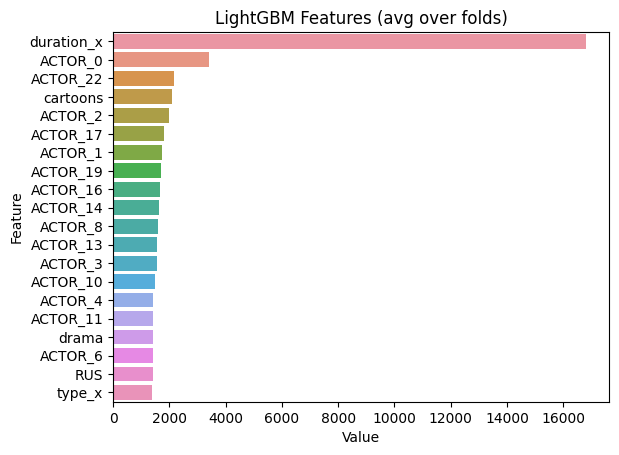

In [36]:
plotImp(model, X , num = 20)

/tmp/ipykernel_220/1279118071.py:69: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test)
/tmp/ipykernel_220/1279118071.py:70: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred)


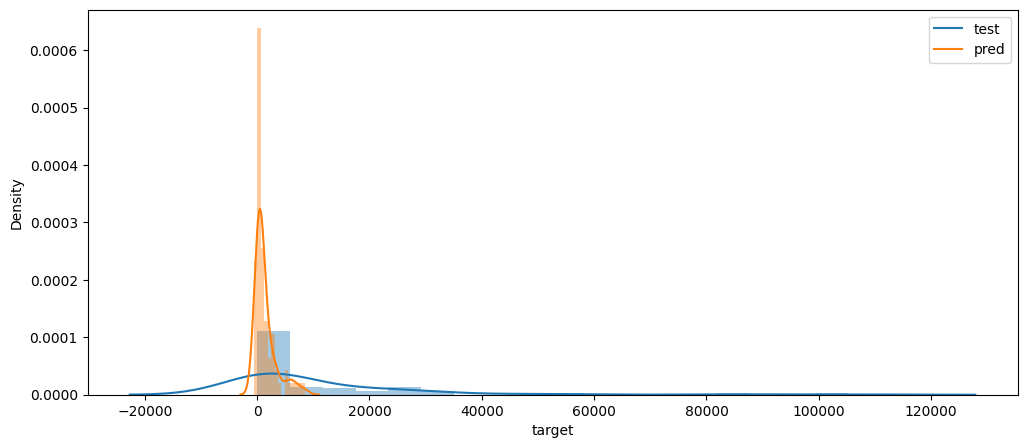

In [37]:
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')

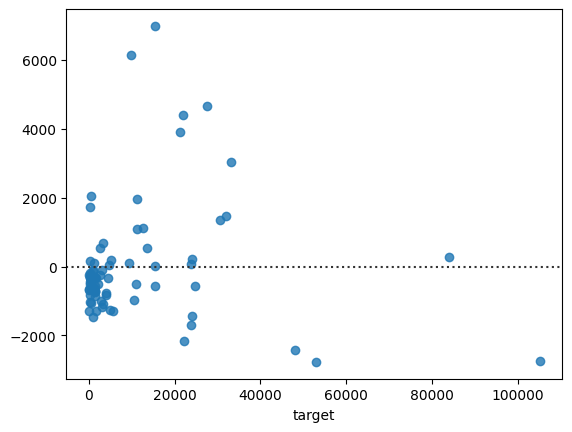

In [38]:
draw_residuals(y_test, y_pred, save_fig=False)

In [39]:
len(y_pred[y_pred <= 0])

10

## 5_1 drop release year

In [51]:
cat_features = ['type', 'subscription_only',
               'top10genre_Drama', 'top10genre_Comedy', 'top10genre_Thriller',
               'top10genre_Action', 'top10genre_Melodrama', 'top10genre_Adventure',
               'top10genre_287a1485-7a88-4c2f-bc94-ca418b6c47a1',
               'top10genre_364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'top10genre_Family',
               'top10genre_Sci-Fi', 'top10actor_d08bba89-e937-40f3-b2a7-7ea26de4c246',
               'top10actor_fd401c6b-3e00-4f7f-aea7-5512df6b91e0',
               'top10actor_5463b4bc-e332-415c-aca8-11c0f217a9eb',
               'top10actor_5f3f6dc9-15fd-464f-91bc-b98c1e467f04',
               'top10actor_bebdaaad-69e1-49c4-ab58-89fc9acafaad',
               'top10actor_9703b641-2566-4e58-aebb-8d140805c0f3',
               'top10actor_fbdae856-85b9-4d4a-96dd-cc383571a488',
               'top10actor_dfd861c4-d2de-4bb6-bc6e-bae3f92a18a9',
               'top10actor_488a47a6-b3e1-40b3-acca-9f605202a040',
               'top10actor_3e94064c-14ef-4f11-9ada-50db5b806557',
               'top3director_751aebbe-2d4d-4421-bace-d44b8e10c8eb',
               'top3director_b5dd6805-5c41-467d-a417-84a7e463a5f6',
               'top3director_f7ded2b9-7c98-47ab-bfc4-57fb60bf946c',
               'top5country_751aebbe-2d4d-4421-bace-d44b8e10c8eb',
               'top5country_b5dd6805-5c41-467d-a417-84a7e463a5f6',
               'top5country_f7ded2b9-7c98-47ab-bfc4-57fb60bf946c', 'RENT', 'DTO',
               'SUBSCRIPTION', 'AVOD']

In [52]:
MULTIPLIER = 100

X, y = df_pr.drop(['target', 'name', 'uid', 'release_year'], axis=1), df_pr['target'] * MULTIPLIER
y = target_transformer.transform(y)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, shuffle=True)
train_dataset = cat.Pool(X_train, y_train,
                         cat_features=cat_features,   
                        ) 
test_dataset = cat.Pool(X_test, y_test,
                         cat_features=cat_features,
                       )
val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features,
                      )

/opt/conda/lib/python3.10/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


In [54]:
import lightgbm as lgb
### We can create a sklearn model of lgb, using the one selected above (learning rate, number of evaluators)
model_lgb = lgb.LGBMRegressor(objective='regression', metric='rmse')

params = {
   'num_leaves': randint(20, 3000) ,
   'min_data_in_leaf': randint(3, 10),
   'max_depth': randint(5, 15),
   'n_estimators': randint(500, 10000),
    'learning_rate': uniform(0.01, 0.5),
}
gsearch1 = RandomizedSearchCV(estimator=model_lgb, param_distributions=params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

In [55]:
gsearch1.fit(X_train, y_train)
gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value

({'learning_rate': 0.015503380182313444,
  'max_depth': 12,
  'min_data_in_leaf': 9,
  'n_estimators': 4655,
  'num_leaves': 63},
 -0.008878653734270141)

In [12]:
# import sklearn
# sklearn.metrics.get_scorer_names()

In [58]:
model = gsearch1.best_estimator_

In [59]:
# with open('5_1', 'wb') as f:
#     pickle.dump(model, f)

with open('5_1', 'rb') as f:
    model = pickle.load(f)

In [60]:
y_pred = model.predict(X_test)

In [61]:
calc_metrics(y_test, y_pred, X)

*** VAL **: 
MSE:   0.02029400677740856
RMSE:  0.14245703484703226
R2:    0.04640054581171116
MAE:   0.054142335719422785
MedAE: 0.020844440453097652
Adj_R2:  0.04286682628851468
------------------------------


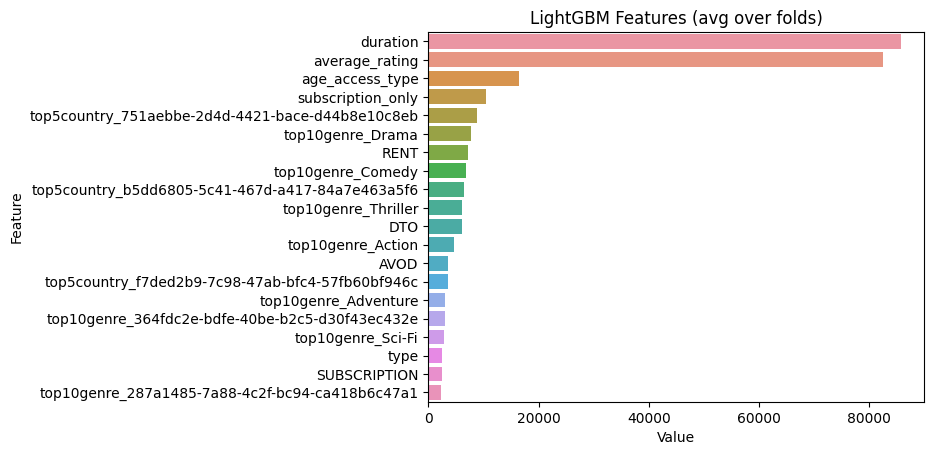

In [62]:
plotImp(model, X , num = 20)

/tmp/ipykernel_48290/753602806.py:72: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test)
/tmp/ipykernel_48290/753602806.py:73: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred)


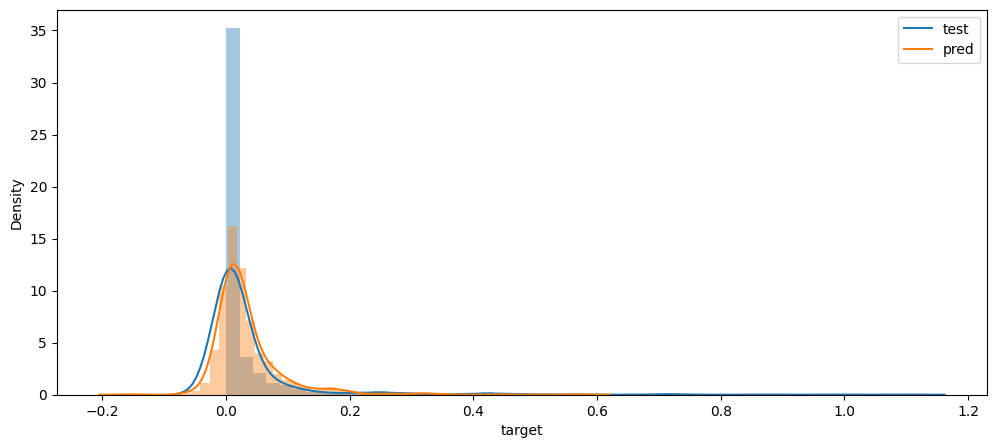

In [63]:
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')

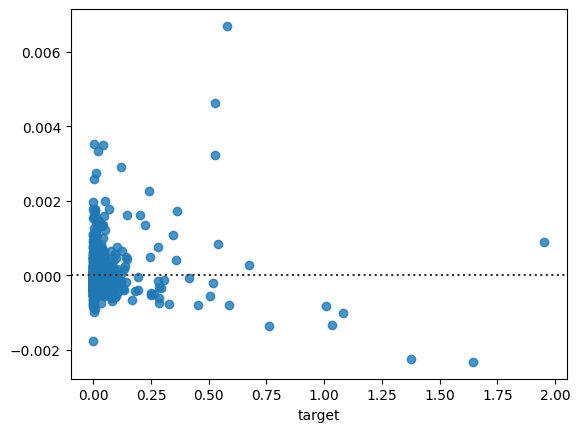

In [64]:
draw_residuals(y_test, y_pred, save_fig=False)

In [65]:
len(y_pred[y_pred <= 0])

153

# 5_2 KNN regressor

In [27]:
from sklearn.preprocessing import OneHotEncoder

In [28]:
MULTIPLIER = 100

X, y = df_pr.drop(['target', 'name', 'uid'], axis=1), df_pr['target'] * MULTIPLIER
y = target_transformer.transform(y)

X['type'] = [1 if 'MOVIE' in t else 0 for t in X['type']]

In [29]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X[['release_year']])
X[enc.get_feature_names_out()] = enc.transform(X[['release_year']]).toarray()

In [30]:
X.drop('release_year', axis=1, inplace=True)

In [31]:
X.columns

Index(['age_access_type', 'average_rating', 'duration', 'type',
       'subscription_only', 'top10genre_Drama', 'top10genre_Comedy',
       'top10genre_Thriller', 'top10genre_Action', 'top10genre_Melodrama',
       'top10genre_Adventure',
       'top10genre_287a1485-7a88-4c2f-bc94-ca418b6c47a1',
       'top10genre_364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'top10genre_Family',
       'top10genre_Sci-Fi', 'top10actor_d08bba89-e937-40f3-b2a7-7ea26de4c246',
       'top10actor_fd401c6b-3e00-4f7f-aea7-5512df6b91e0',
       'top10actor_5463b4bc-e332-415c-aca8-11c0f217a9eb',
       'top10actor_5f3f6dc9-15fd-464f-91bc-b98c1e467f04',
       'top10actor_bebdaaad-69e1-49c4-ab58-89fc9acafaad',
       'top10actor_9703b641-2566-4e58-aebb-8d140805c0f3',
       'top10actor_fbdae856-85b9-4d4a-96dd-cc383571a488',
       'top10actor_dfd861c4-d2de-4bb6-bc6e-bae3f92a18a9',
       'top10actor_488a47a6-b3e1-40b3-acca-9f605202a040',
       'top10actor_3e94064c-14ef-4f11-9ada-50db5b806557',
       'top3director_75

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, shuffle=True)

In [33]:
from sklearn.preprocessing import MinMaxScaler
num_features = ['age_access_type', 'average_rating', 'duration']
scaler = MinMaxScaler()
scaler.fit(X_train[num_features])

X_train[num_features] = scaler.transform(X_train[num_features])
X_val[num_features] = scaler.transform(X_val[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])


In [39]:
X_train

,age_access_type,average_rating,duration,type,subscription_only,top10genre_Drama,top10genre_Comedy,top10genre_Thriller,top10genre_Action,top10genre_Melodrama,...,release_year_2013.0,release_year_2014.0,release_year_2015.0,release_year_2016.0,release_year_2017.0,release_year_2018.0,release_year_2019.0,release_year_2020.0,release_year_2021.0,release_year_2022.0
5447,0.888889,0.507115,0.189266,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6017,0.888889,0.560155,0.186032,1,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7733,0.000000,0.739974,0.463424,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3668,0.666667,0.875809,0.259854,1,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3085,1.000000,0.627426,0.136296,1,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,1.000000,0.390686,0.186032,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5191,0.888889,0.610608,0.198579,1,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5390,1.000000,0.745149,0.204488,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
860,0.666667,0.868047,0.189266,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor()

params = {
   'n_neighbors': randint(3, 8) ,
   'weights': ['uniform', 'distance']
}
gsearch1 = RandomizedSearchCV(estimator=neigh, param_distributions=params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

In [35]:
gsearch1.fit(X_train, y_train)
gsearch1.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_neighbors': 6, 'weights': 'uniform'}

In [40]:
model = gsearch1.best_estimator_

In [57]:
# with open('5_2', 'wb') as f:
#     pickle.dump(model, f)

# with open('5_1', 'rb') as f:
#     model = pickle.load(f)

In [44]:
y_pred = model.predict(X_test)

In [45]:
calc_metrics(y_test, y_pred, X)

*** VAL **: 
MSE:   0.016708968348082342
RMSE:  0.12926317475631774
R2:    0.2148586885011693
MAE:   0.04237801566267244
MedAE: 0.011043061882061955
Adj_R2:  0.21002551124931912
------------------------------


/tmp/ipykernel_48290/753602806.py:72: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test)
/tmp/ipykernel_48290/753602806.py:73: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred)


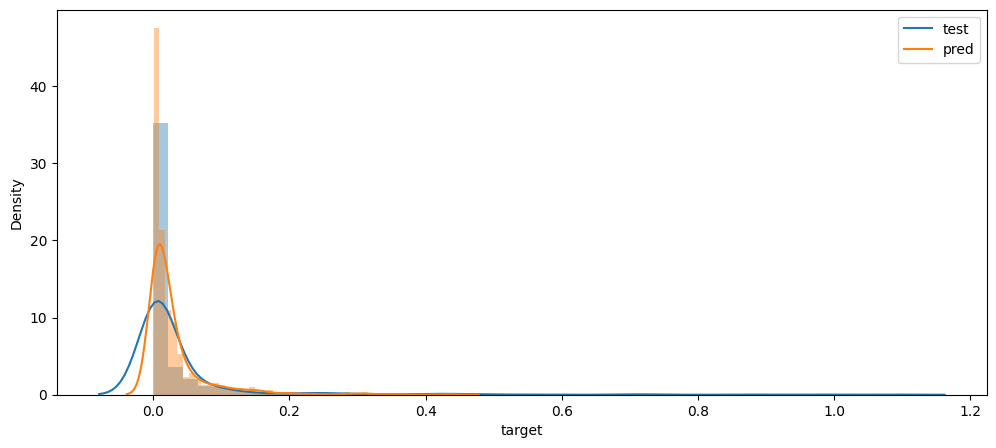

In [46]:
draw_target_distr(y_test, y_pred, save_fig=False, file_name='cat_distribution')

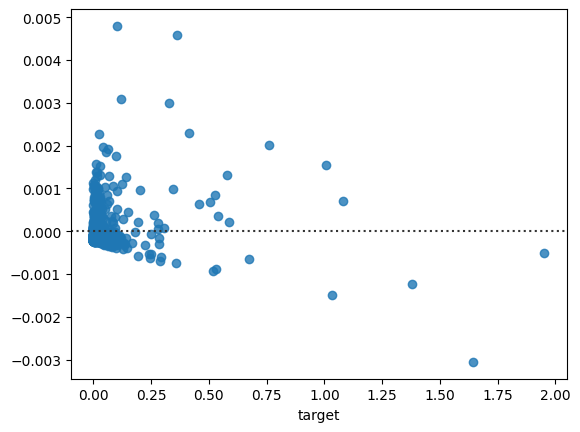

In [47]:
draw_residuals(y_test, y_pred, save_fig=False)

In [48]:
len(y_pred[y_pred <= 0])

0